# 데이터

### 데이터 불러오기

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split


# 이미지 파일 불러오기
def load_images_from_folder(folder):
    images = []
    labels = []
    label = folder.split('/')[-1]
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((32, 32))
        img = np.array(img)
        images.append(img)
        labels.append(label)

    return images, labels

# 이미지 데이터셋 로드
cat_images, cat_labels = load_images_from_folder('./data/cats')
dog_images, dog_labels = load_images_from_folder('./data/dogs')

In [2]:
print(f"고양이 데이터 갯수: {len(cat_labels)}")
print(f"강아지 데이터 갯수: {len(dog_labels)}")

고양이 데이터 갯수: 10
강아지 데이터 갯수: 10


### 데이터 시각화

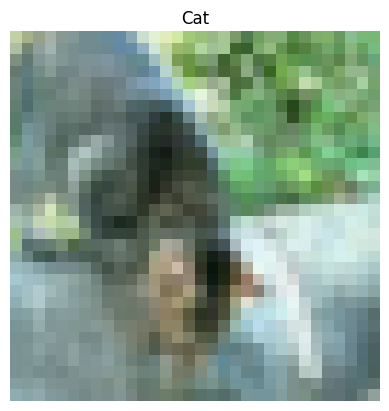

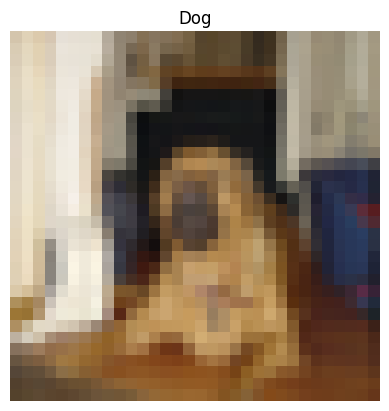

In [3]:
import matplotlib.pyplot as plt


# 한 장씩 시각화
def visualize_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 고양이 이미지 한 장 시각화
visualize_image(cat_images[0], 'Cat')

# 강아지 이미지 한 장 시각화
visualize_image(dog_images[0], 'Dog')

### 레이블 벡터화

In [4]:
# 데이터와 레이블 병합
images = np.array(cat_images + dog_images)
labels = np.array(cat_labels + dog_labels)

# 레이블을 숫자로 변환
label_to_index = {'cats': 0, 'dogs': 1}
indexed_labels = np.array([label_to_index[label] for label in labels])

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(images, indexed_labels, test_size=0.2, random_state=42)


### PyTorch Custom 데이터 세트

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset 정의
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        """
        이미지와 레이블을 받아 데이터셋 객체를 초기화합니다.

        Args:
            images (numpy.ndarray): 이미지 데이터 배열 (예: shape가 (N, 32, 32, 3)인 배열).
            labels (numpy.ndarray): 각 이미지에 대한 레이블 배열 (예: shape가 (N,)인 배열).
        """
        self.images = images  # 이미지 데이터 배열을 저장
        self.labels = labels  # 레이블 배열을 저장

    def __len__(self):
        """
        데이터셋의 총 샘플 수를 반환합니다.

        Returns:
            int: 데이터셋의 샘플 수.
        """
        return len(self.labels)  # 레이블 배열의 길이를 반환

    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 샘플을 반환합니다.

        Args:
            idx (int): 샘플의 인덱스.

        Returns:
            tuple: (이미지, 레이블)로 구성된 튜플.
        """
        image = self.images[idx]  # 주어진 인덱스에 해당하는 이미지 가져오기
        label = self.labels[idx]  # 주어진 인덱스에 해당하는 레이블 가져오기
        
        # 이미지를 torch 텐서로 변환하고, float32 타입으로 캐스팅한 후, 차원 순서를 (채널, 높이, 너비)로 변경
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        # 레이블을 torch 텐서로 변환하고, float32 타입으로 캐스팅
        # CrossEntropyLoss는 float형 레이블을 기대함
        label = torch.tensor(label, dtype=torch.float32)  
        
        return image, label  # 변환된 이미지와 레이블을 반환

In [6]:
# 데이터 로더 생성
train_dataset = ImageDataset(X_train, y_train)
test_dataset = ImageDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model

In [7]:
import torch.nn as nn

# 모델 정의
class SimpleFC(nn.Module):
    def __init__(self):
        """
        SimpleFC 클래스의 초기화 메서드입니다.
        세 개의 선형 (fully connected) 레이어를 정의합니다.
        """
        super(SimpleFC, self).__init__()
        # 첫 번째 선형 레이어: 입력 노드 수는 32 * 32 * 3 (32x32 크기의 RGB 이미지), 출력 노드 수는 128
        self.fc1 = nn.Linear(32 * 32 * 3, 128)
        # 두 번째 선형 레이어: 입력 노드 수는 128, 출력 노드 수는 64
        self.fc2 = nn.Linear(128, 64)
        # 세 번째 선형 레이어: 입력 노드 수는 64, 출력 노드 수는 1 (이진 분류를 위한 로짓 출력)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        """
        순전파 (forward pass) 메서드입니다.
        입력 x를 모델을 통해 순차적으로 통과시킵니다.
        
        Args:
            x (torch.Tensor): 입력 텐서, shape (batch_size, 3, 32, 32)
            
        Returns:
            torch.Tensor: 최종 출력 텐서, shape (batch_size, 1)
        """
        # 입력 x의 크기를 (batch_size, 3, 32, 32)에서 (batch_size, 32 * 32 * 3)로 변경
        x = x.view(x.size(0), -1)
        # 첫 번째 레이어를 통과한 후 ReLU 활성화 함수 적용
        x = torch.relu(self.fc1(x))
        # 두 번째 레이어를 통과한 후 ReLU 활성화 함수 적용
        x = torch.relu(self.fc2(x))
        # 세 번째 레이어를 통과한 후 최종 출력
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x

# SimpleFC 클래스의 인스턴스를 생성하여 모델을 초기화
model = SimpleFC()

# Optimization

In [8]:
import torch.optim as optim

# 옵티마이저 정의
# 모델의 매개변수 (parameters)를 전달하고, 학습률 (learning rate)을 0.001로 설정
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Loss

In [9]:
# 손실 함수 정의
# CrossEntropyLoss는 클래스 레이블을 정수로 받고, 모델의 출력은 클래스에 대한 raw 점수 (logits)여야 합니다.
# 이 손실 함수는 내부적으로 Softmax를 적용하여 클래스 확률을 계산하고, 실제 레이블과의 차이를 측정합니다.
criterion = nn.BCELoss()

# Train

In [10]:
# 학습 루프
num_epochs = 10  # 총 학습 에폭 수를 10으로 설정

# 각 에폭(epoch)마다 반복
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0  # 에폭 동안의 손실을 누적하기 위한 변수 초기화
    
    # 학습 데이터 로더에서 배치(batch) 단위로 데이터를 가져옴
    for images, labels in train_loader:
        optimizer.zero_grad()  # 옵티마이저의 변화도(gradients)를 초기화
        outputs = model(images).squeeze()  # 모델에 이미지를 입력하여 예측값 출력, 출력의 차원 축소
        loss = criterion(outputs, labels)  # 예측값과 실제 레이블을 사용하여 손실 계산
        loss.backward()  # 손실에 대한 변화도(gradients) 계산
        optimizer.step()  # 옵티마이저가 모델의 매개변수를 업데이트
        
        running_loss += loss.item()  # 배치의 손실을 누적
    
    # 에폭이 끝날 때마다 평균 손실 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

Epoch [1/10], Loss: 0.6934572160243988
Epoch [2/10], Loss: 0.6926301270723343
Epoch [3/10], Loss: 0.6924353241920471
Epoch [4/10], Loss: 0.6916584074497223
Epoch [5/10], Loss: 0.6911292225122452
Epoch [6/10], Loss: 0.6907039433717728
Epoch [7/10], Loss: 0.6901939809322357
Epoch [8/10], Loss: 0.6900702863931656
Epoch [9/10], Loss: 0.6894718557596207
Epoch [10/10], Loss: 0.6890570819377899


# Test

In [11]:
# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images).squeeze()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 50.0%
